# Clustering

In [422]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.special as sp
import pycodamath as coda
from pycodamath import plot
from pycodamath import extra
import scipy.optimize as optimization

#### 1. Data Loading

In [423]:
import pandas as pd
import re

# Load data
data = pd.read_csv('../data/2-meteorites.csv', sep=',')
data.rename(columns={'Unnamed: 0': 'Location'}, inplace=True)

# Strip leading and trailing spaces from all column names
data.columns = data.columns.str.strip()

# Extract the part inside parentheses into 'Type'
data['Type'] = data['Location'].str.extract(r'\((.*?)\)')

# Remove the parentheses and content from 'Location'
data['Location'] = data['Location'].str.replace(r'\s*\(.*?\)', '', regex=True).str.strip()

# Reorder columns: Location, Type, then the rest
cols = ['Location', 'Type'] + [col for col in data.columns if col not in ['Location', 'Type']]
data = data[cols]
data.iloc[:, 2:] = data.iloc[:, 2:].coda.closure(100)

# Check result
print(data.head())
print(data.shape)


    Location Type       SiO2     Al2O3        FeO       MnO        MgO  \
0    Allende   cc  37.915374  3.622065  30.073106  0.199380  27.270713   
1       Bali   cc  37.892729  3.545781  29.746409  0.213196  27.535907   
2  Efremovka   cc  39.220393  3.852309  19.661637  0.217193  28.246456   
3   Coolidge   cc  42.960559  4.131303   9.061408  0.299551  31.190714   
4    Ankober   hc  39.378411  2.584382  14.537150  0.356467  25.465077   

          Fe        Ni        Co         C  
0   0.188303  0.398759  0.011077  0.321223  
1   0.168312  0.246858  0.011221  0.639587  
2   6.298583  1.566072  0.068587  0.868770  
3  10.334498  1.684973  0.099850  0.237144  
4  15.550852  1.904868  0.111396  0.111396  
(12, 11)


#### 2. PCA

In [424]:
import numpy as np
import pandas as pd

# Apply transformations
clr_data = data.iloc[:, 2:].coda.center().coda.scale().coda.clr().values

# Run SVD directly
u, s, vt = np.linalg.svd(clr_data, full_matrices=False)

loadings = pd.DataFrame(vt.T * s, index=data.columns[2:], columns=[f'pc{i+1}' for i in range(vt.shape[0])])

# Psi matric
psi = vt.T

# Removing the last column of psi
psi = psi[:, :-1]

#### 3. SOM

In [425]:
# Select label columns
label_data = data.iloc[:, :2]
# Select numerical (compositional) columns
numerical_data = data.iloc[:, 2:]
# Apply CLR transform on numerical part
clr_data = numerical_data.coda.clr()

# Combine labels and transformed data
combined_data = pd.concat([label_data, clr_data], axis=1)

# Extract just the clr-transformed numerical part for SOM
som_input = clr_data.values  # shape (n_samples, n_features)


from minisom import MiniSom

# Define SOM grid (for example: 10x10)
som = MiniSom(x=10, y=10, input_len=som_input.shape[1], sigma=1.0, learning_rate=0.5)

# Initialize weights
som.random_weights_init(som_input)

# Train SOM
som.train_random(som_input, num_iteration=1000)


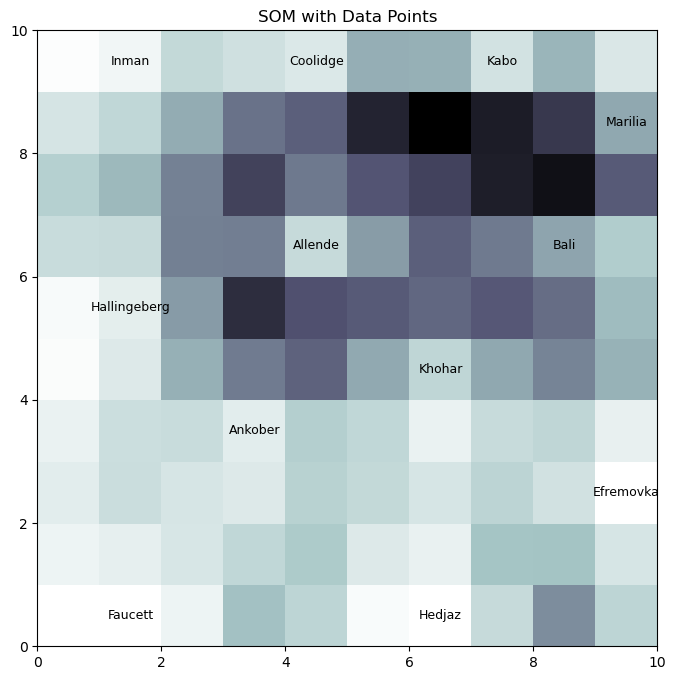

In [426]:


# Example: using first label column as a category
labels = label_data.iloc[:, 0]

plt.figure(figsize=(8, 8))
plt.pcolor(som.distance_map().T, cmap='bone_r')  # background U-matrix

# Plot each data point
for i, x in enumerate(som_input):
    w = som.winner(x)  # (x, y) position on the SOM grid
    plt.plot(w[0] + 0.5, w[1] + 0.5, markerfacecolor='None',
              markersize=12, markeredgewidth=2)
    plt.text(w[0] + 0.5, w[1] + 0.5, str(labels.iloc[i]),
             fontsize=9, ha='center', va='center')

plt.title('SOM with Data Points')
#plt.savefig('../handin/figures/som_with_data_points.png', dpi=300)
plt.show()


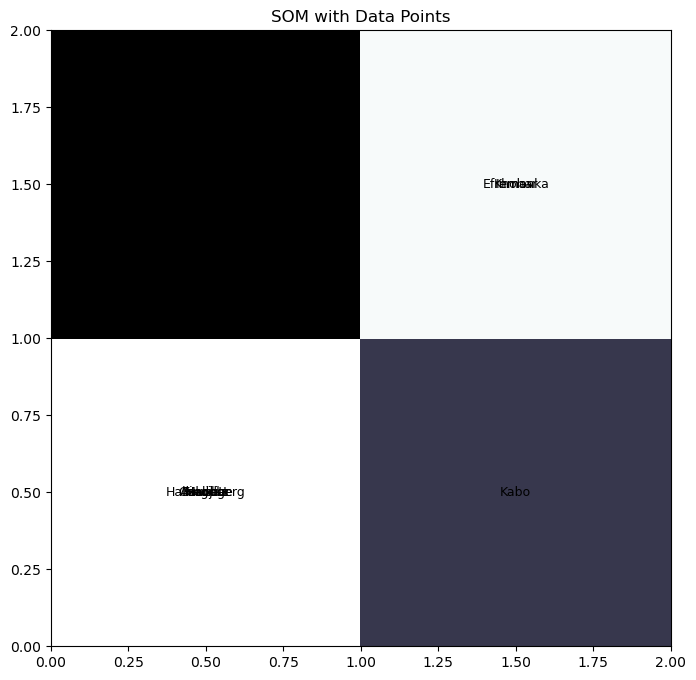

Number of unique SOM node clusters: 4

Clustered data (first few rows):
    Location Type      SiO2     Al2O3       FeO       MnO       MgO        Fe  \
0    Allende   cc  3.436283  1.087970  3.204557 -1.811618  3.106739 -1.868777   
1       Bali   cc  3.418606  1.049605  3.176555 -1.761698  3.099337 -1.998087   
2  Efremovka   cc  2.638185  0.317661  1.947658 -2.557983  2.309957  0.809313   
3   Coolidge   cc  2.790103  0.448413  1.233845 -2.175651  2.469941  1.365308   
4    Ankober   hc  2.728284  0.004553  1.731774 -1.976448  2.292375  1.799182   

         Ni        Co         C  SOM_NodeCluster  
0 -1.118471 -4.701990 -1.334694                0  
1 -1.615095 -4.706137 -0.663086                0  
2 -0.582441 -3.710662 -1.171688                2  
3 -0.448430 -3.274263 -2.409266                3  
4 -0.300521 -3.139599 -3.139599                3  


In [427]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from minisom import MiniSom
from collections import defaultdict
from sklearn.cluster import KMeans

# --------------------
# Step 1: Select label + numerical columns, apply CLR
# --------------------

# Select label columns
label_data = data.iloc[:, :2]

# Select numerical (compositional) columns
numerical_data = data.iloc[:, 2:]

# Apply CLR transform on numerical part
clr_data = numerical_data.coda.clr()

# Combine labels and transformed data
combined_data = pd.concat([label_data, clr_data], axis=1)

# Extract just the clr-transformed numerical part for SOM
som_input = clr_data.values  # shape (n_samples, n_features)

# --------------------
# Step 2: Define and train SOM
# --------------------

som_x, som_y = 2, 2  # grid size
som = MiniSom(x=som_x, y=som_y, input_len=som_input.shape[1], sigma=1.0, learning_rate=0.5)

som.random_weights_init(som_input)
som.train_random(som_input, num_iteration=1000)

# --------------------
# Step 3: Visualize initial SOM with labels
# --------------------

labels = label_data.iloc[:, 0]  # first label column

plt.figure(figsize=(8, 8))
plt.pcolor(som.distance_map().T, cmap='bone_r')  # background U-matrix

# Plot each data point
for i, x in enumerate(som_input):
    w = som.winner(x)
    plt.plot(w[0] + 0.5, w[1] + 0.5, markerfacecolor='None',
             markersize=12, markeredgewidth=2)
    plt.text(w[0] + 0.5, w[1] + 0.5, str(labels.iloc[i]),
             fontsize=9, ha='center', va='center')

plt.title('SOM with Data Points')
plt.show()

# --------------------
# Step 4: Extract SOM node clusters (basic)
# --------------------

# Get winner nodes (convert each to tuple)
winners = np.array([som.winner(x) for x in som_input])
winners_as_tuples = [tuple(w) for w in winners]

# Group indices by SOM node
cluster_map = defaultdict(list)
for idx, node in enumerate(winners_as_tuples):
    cluster_map[node].append(idx)

# Assign unique cluster IDs based on SOM nodes
unique_nodes = list(set(winners_as_tuples))
node_to_cluster = {node: i for i, node in enumerate(unique_nodes)}
basic_cluster_labels = np.array([node_to_cluster[node] for node in winners_as_tuples])

print(f"Number of unique SOM node clusters: {len(unique_nodes)}")


# --------------------
# Step 6: Add cluster labels to DataFrame
# --------------------

# Create a copy of the combined data with labels + clr
clustered_data = combined_data.copy()
clustered_data['SOM_NodeCluster'] = basic_cluster_labels

print("\nClustered data (first few rows):")
print(clustered_data.head())



In [428]:
data['SOM_NodeCluster'] = clustered_data['SOM_NodeCluster']

In [429]:
data[['Location', 'Type', 'SOM_NodeCluster']]

,Location,Type,SOM_NodeCluster
0,Allende,cc,0
1,Bali,cc,0
2,Efremovka,cc,2
3,Coolidge,cc,3
4,Ankober,hc,3
5,Faucett,hc,3
6,Kabo,hc,1
7,Marilia,hc,3
8,Inman,lc,2
9,Khohar,lc,2


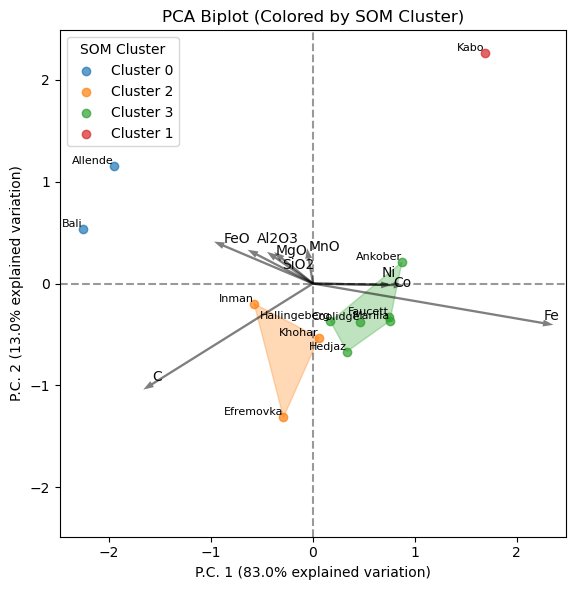

In [430]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull

# Define colors for each SOM cluster
unique_clusters = data['SOM_NodeCluster'].unique()
color_map = {cluster_label: color for cluster_label, color in zip(unique_clusters, plt.cm.tab10.colors)}

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create the biplot object, telling it to use ax
mypca = coda.pca.Biplot(data.iloc[:, 2:-1], axis=ax, default=False)

# Plot loadings
mypca.plotloadings()
mypca.adjustloadinglabels()
ax.set_title('PCA Biplot (Colored by SOM Cluster)')

# Plot points and convex hulls per cluster
for cluster_label in unique_clusters:
    indices = data[data['SOM_NodeCluster'] == cluster_label].index
    samples = mypca.scores.columns[indices]
    x = np.array([mypca.scores.loc['pc1', s] for s in samples])
    y = np.array([mypca.scores.loc['pc2', s] for s in samples])
    
    # Scatter plot points
    ax.scatter(x, y, color=color_map[cluster_label], label=f'Cluster {cluster_label}', alpha=0.7)
    
    # Draw convex hull if at least 3 points
    if len(x) >= 3:
        points = np.column_stack((x, y))
        hull = ConvexHull(points)
        vertices = np.append(hull.vertices, hull.vertices[0])  # close the loop
        ax.fill(points[vertices, 0], points[vertices, 1], color=color_map[cluster_label], alpha=0.3)

    # Annotate each point with location
    for i, s in zip(indices, samples):
        location_label = data.loc[i, 'Location']
        ax.text(mypca.scores.loc['pc1', s], mypca.scores.loc['pc2', s],
                str(location_label), fontsize=8, ha='right', va='bottom')

# Add legend
ax.legend(title='SOM Cluster')

plt.tight_layout()
#plt.savefig('../handin/figures/pca_biplot_som_convexhull.png', dpi=300, bbox_inches='tight')
plt.show()


In [431]:
#
#from geopy.geocoders import Nominatim
#import pandas as pd
#import time
#
## Example data
#locations = data['Location']
#
## Initialize geocoder
#geolocator = Nominatim(user_agent="my_geocoder")
#
## Store results
#latitudes = []
#longitudes = []
#
#for place in locations:
#    try:
#        location = geolocator.geocode(place)
#        if location:
#            latitudes.append(location.latitude)
#            longitudes.append(location.longitude)
#        else:
#            latitudes.append(None)
#            longitudes.append(None)
#    except Exception as e:
#        print(f"Error geocoding {place}: {e}")
#        latitudes.append(None)
#        longitudes.append(None)
#    
#    time.sleep(1)  # To avoid hitting rate limits
#
## Add to dataframe
#data['Latitude'] = latitudes
#data['Longitude'] = longitudes
#
##print(data[['Location', 'Latitude', 'Longitude']])
#latitudes

In [432]:
latitudes = [19.435551,
 -8.2271303,
 52.535145,
 32.977839,
 9.5911547,
 39.6006007,
 12.8266035,
 -22.2172002,
 38.2320232,
 24.6353268,
 31.9685052,
 57.8302405]
longitudes = [-99.1371341,
 115.1919203,
 77.343155,
 -111.517624,
 39.7338213,
 -94.801019,
 -2.2448334,
 -49.9500061,
 -97.7733326,
 81.920713,
 35.9681828,
 16.2502114]

data['Latitude'] = latitudes
data['Longitude'] = longitudes

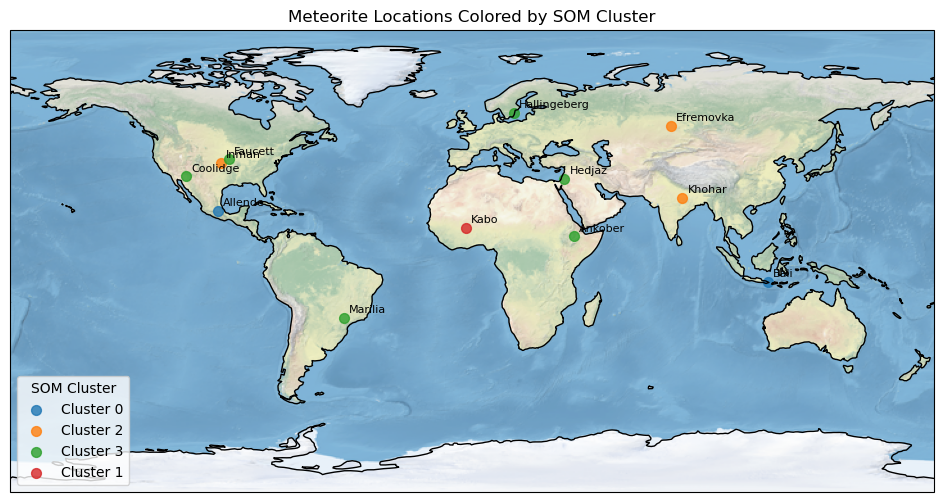

In [433]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.cm as cm

# Make sure column names are clean
data.columns = data.columns.str.strip()

# Define colors for each SOM cluster
unique_clusters = data['SOM_NodeCluster'].unique()
color_map = {cluster_label: color for cluster_label, color in zip(unique_clusters, plt.cm.tab10.colors)}

# Create figure and map
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.add_feature(cfeature.COASTLINE)

# Plot points by cluster
for cluster_label in unique_clusters:
    cluster_data = data[data['SOM_NodeCluster'] == cluster_label]
    ax.scatter(cluster_data['Longitude'], cluster_data['Latitude'],
               color=color_map[cluster_label], s=50, label=f'Cluster {cluster_label}',
               transform=ccrs.PlateCarree(), alpha=0.8)

# Add location names
for idx, row in data.iterrows():
    ax.text(row['Longitude'] + 2, row['Latitude'] + 2,  # offset to avoid overlap
            str(row['Location']),
            fontsize=8,
            transform=ccrs.PlateCarree())

# Add legend
ax.legend(title='SOM Cluster', loc='lower left')

plt.title('Meteorite Locations Colored by SOM Cluster')
plt.savefig('../handin/figures/locations_clusters.png', dpi=300, bbox_inches='tight')
plt.show()


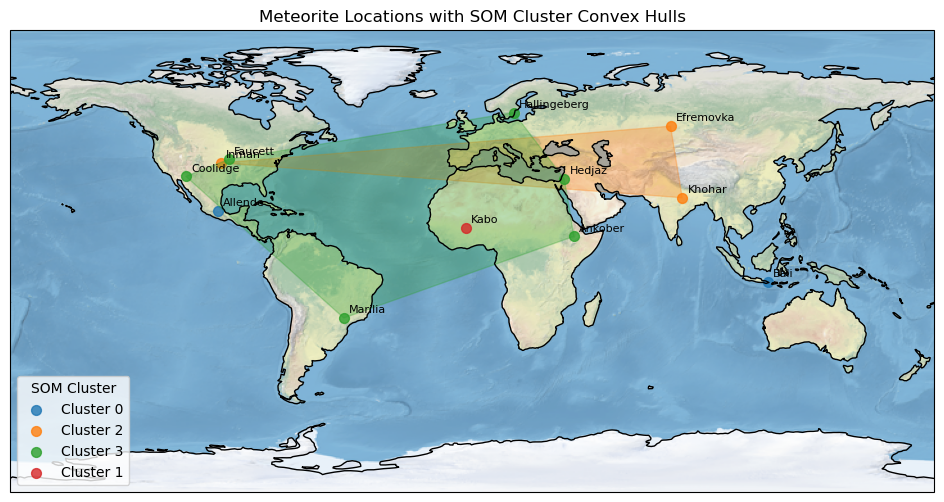

In [434]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.cm as cm
import numpy as np
from scipy.spatial import ConvexHull

# Make sure column names are clean
data.columns = data.columns.str.strip()

# Define colors for each SOM cluster
unique_clusters = data['SOM_NodeCluster'].unique()
color_map = {cluster_label: color for cluster_label, color in zip(unique_clusters, plt.cm.tab10.colors)}

# Create figure and map
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.add_feature(cfeature.COASTLINE)

# Plot points by cluster and draw convex hull
for cluster_label in unique_clusters:
    cluster_data = data[data['SOM_NodeCluster'] == cluster_label]
    
    # Scatter points
    ax.scatter(cluster_data['Longitude'], cluster_data['Latitude'],
               color=color_map[cluster_label], s=50, label=f'Cluster {cluster_label}',
               transform=ccrs.PlateCarree(), alpha=0.8)
    
    # Draw convex hull if at least 3 points
    if len(cluster_data) >= 3:
        points = np.column_stack((cluster_data['Longitude'], cluster_data['Latitude']))
        hull = ConvexHull(points)
        vertices = np.append(hull.vertices, hull.vertices[0])  # close the loop
        
        ax.fill(points[vertices, 0], points[vertices, 1],
                color=color_map[cluster_label], alpha=0.3,
                transform=ccrs.PlateCarree())

# Add location names
for idx, row in data.iterrows():
    ax.text(row['Longitude'] + 2, row['Latitude'] + 2,  # offset to avoid overlap
            str(row['Location']),
            fontsize=8,
            transform=ccrs.PlateCarree())

# Add legend
ax.legend(title='SOM Cluster', loc='lower left')

plt.title('Meteorite Locations with SOM Cluster Convex Hulls')
#plt.savefig('../handin/figures/locations_clusters_convexhull.png', dpi=300, bbox_inches='tight')
plt.show()
